## Model Training

- Single Layer LSTM
- Multiple Layers LSTM
- LSTM with Attention

In [94]:
# Import necessities
import os
import datetime
import pickle as pkl
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Activation, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Set plotting style
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [95]:
# Readning in the dataset
dataset_csv = pd.read_csv('./data/dataset.csv', index_col=0)
dataset_rolling_csv = pd.read_csv('./data/dataset_rolling.csv', index_col=0)

In [117]:
class Dataset():
    def __init__(self, dataset, feature_cols, label_cols, timestamp=14, 
                        batch_size=1, test_size=0.03):
        ''' Initialize the dataset
        :param dataset: Dataframe of the dataset
        :param feature_cols: list of feature names,
            e.g. ['dates', 'vaccinations'] means using dates and vaccinations as features
        :param label_cols: list of prediction targets,
            e.g. ['confirmed'] means using confirmed data as labels
        :param timestamp: timestamp in LSTM model
        :param test_size: the ratio of test data in the dataset
        '''
        self.dataset = dataset
        self.feature_cols = feature_cols
        self.label_cols = label_cols
        self.timestamp = timestamp
        self.batch_size = batch_size
        self.test_size = test_size
        # Split features and labels
        self.features = self.dataset[feature_cols]
        self.labels = self.dataset[label_cols]
        # Normalize the dataset using MinMaxScaler before training
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.dataset.loc[:, dataset.columns != 'dates'] = self.scaler.fit_transform(dataset.loc[:, dataset.columns != 'dates'])
        # Split the dataset
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
                self.features, self.labels, test_size=self.test_size, shuffle=False)
    
    def get_training_set(self):
        ''' Return the time-series generator used for training
        '''
        return TimeseriesGenerator(self.x_train.to_numpy(), self.y_train.to_numpy(),
                length=self.timestamp, batch_size=self.batch_size)
    
    def get_test_set(self):
        ''' Return the time-series generator used for testing
        '''
        # Add overlapping points to test set
        x_test = pd.concat([self.x_train[-self.timestamp:], self.x_test])
        y_test = pd.concat([self.y_train[-self.timestamp:], self.y_test])
        return TimeseriesGenerator(x_test.to_numpy(), y_test.to_numpy(),
                length=self.timestamp, batch_size=self.batch_size)

In [137]:
class BaseModel():
    ''' Other models are derived by inheritance from BaseModel.
    '''
    def __init__(self, dataset, model_path, output_dim, epochs,
                        verbose, loss, optimizer, dropout, **args):
        ''' Initialize the model parameters
        param dataset: dataset Dataframe
        param output_dim: output dimension
        param epochs: training epochs
        param verbose: verbose level of logging
        param loss: loss function for training
        param optimizer: optimizer for training
        '''
        self.dataset = dataset
        self.model_path = model_path
        self.output_dim = output_dim
        self.epochs = epochs
        self.verbose = verbose
        self.loss = loss
        self.optimizer = optimizer
        self.dropout = dropout
    
    def read_model(self):
        ''' Load model from the given path
        '''
        self.model = load_model(self.model_path)

    def train(self):
        ''' Training
        '''
        training_set = self.dataset.get_training_set()
        self.model.fit(training_set, epochs=self.epochs, verbose=self.verbose)
    
    def save_model(self):
        ''' Save model to path
        '''
        self.model.save(self.model_path)
    
    def predict(self, input):
        return self.model.predict(input)

    def evaluate(self):
        return self.model.evaluate(self.dataset.get_test_set())
    
    def plot(self):
        plt.figure(figsize=(10, 8))
        plt.title('Labels and Predictions on ' + ', '.join(self.dataset.label_cols))
        len_train = len(self.dataset.y_train)
        len_test = len(self.dataset.y_test)
        plt.plot(range(0, len_train), self.dataset.y_train, label='y_train')
        plt.plot(range(self.dataset.timestamp, len_train), self.model.predict(self.dataset.get_training_set()), label='pred_train')
        plt.plot(range(len_train, len_train+len_test), self.dataset.y_test, label='y_test')
        plt.plot(range(len_train, len_train+len_test), self.model.predict(self.dataset.get_test_set()), label='pred_test')
        plt.legend()
        plt.show()
        

In [138]:
class LSTMModel(BaseModel):
    ''' LSTM models structures and implementation.
    '''
    def __init__(self, dataset=None, model_path='', model_type='',
                        output_dim=64, epochs=300, verbose=1,
                        loss='mse', optimizer='adam', dropout=0.2,
                        share_attention=False, **args):
        ''' Initialize the model parameters
        param dataset: dataset Dataframe
        param output_dim: output dimension
        param epochs: training epochs
        param verbose: verbose level of logging
        param loss: loss function for training
        param optimizer: optimizer for training
        '''
        super(LSTMModel, self).__init__(dataset, model_path,
                                        output_dim, epochs, verbose,
                                        loss, optimizer, dropout, **args)
        self.share_attention = share_attention
    
    def attention_block(input):
        ''' Attention block
        '''
        # (batch_size, time_steps, input_dim)
        input_dim = int(input.shape[2])
        # Transpose with Permute
        a = Permute((2, 1))(inputs)
        a = Reshape((input_dim, self.dataset.timestamp))(a)
        a = Dense(self.dataset.timestamp, activation='softmax')(a)
        if self.share_attention:
            a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
            a = RepeatVector(input_dim)(a)
        a_probs = Permute((2, 1), name='attention_vec')(a)
        return Multiply()([inputs, a_probs])

    def construct_single_layer_lstm(self):
        self.model = Sequential()
        self.model.add(LSTM(units=self.output_dim, input_shape=(self.dataset.timestamp, len(self.dataset.feature_cols))))
        # self.model.add(Dropout(self.dropout))
        self.model.add(Dense(units=len(self.dataset.label_cols)))
        # Activation Functions
        # self.model.add(Activation("sigmoid"))
        # self.model.add(Activation("linear"))
        # self.model.add(Activation("relu"))
        # MSE loss and adam optimizer
        self.model.compile(loss=self.loss, optimizer=self.optimizer)

    def construct_multi_layer_lstm(self):
        self.model = Sequential()
        # Three-layer LSTM with Dropout
        self.model.add(LSTM(units=self.output_dim, return_sequences=True, input_shape=(self.dataset.timestamp, len(self.dataset.feature_cols))))
        # self.model.add(Dropout(self.dropout))
        self.model.add(LSTM(units=self.output_dim, return_sequences=True))
        # self.model.add(Dropout(self.dropout))
        self.model.add(LSTM(units=self.output_dim, return_sequences=False))
        # self.model.add(Dropout(self.dropout))
        # Dense Layer
        self.model.add(Dense(units=len(self.dataset.label_cols)))
        # Activation Functions
        # self.model.add(Activation("sigmoid"))
        # self.model.add(Activation("linear"))
        # self.model.add(Activation("relu"))
        # MSE loss and adam optimizer
        self.model.compile(loss=self.loss, optimizer=self.optimizer)

    def construct_attention_lstm(self):
        inputs = Input(shape=(self.dataset.timestamp, len(self.dataset.feature_cols)))
        attention = self.attention_block(input)
        attention = LSTM(units=self.output_dim, return_sequences=False)(attention)
        output = Dense(1, activation='sigmoid')(attention)
        self.model = Model(input=[inputs], output=output)

    def construct_lstm_attention(self):
        # Inputs Layer
        inputs = Input(shape=(self.dataset.timestamp, len(self.dataset.feature_cols)))
        # Single LSTM Layer
        lstm = LSTM(units=self.output_dim, return_sequences=True)(inputs)
        # Attention Block
        attention = attention_block(lstm)
        # Flatten to connect with Dense Layer
        attention = Flatten()(attention)
        output = Dense(1, activation='sigmoid')(attention)
        self.model = Model(input=[inputs], output=output)

    def construct_model(self, model_type='single_layer_lstm'):
        ''' Build model from scratch
        param model_type:
            - single_layer_lstm
            - multi_layer_lstm
            - attention_lstm
            - lstm_attention
            - transformer
        '''
        if model_type is 'single_layer_lstm':
            self.construct_single_layer_lstm()
        elif model_type is 'multi_layer_lstm':
            self.construct_multi_layer_lstm()
        elif model_type is 'attention_lstm':
            self.construct_attention_lstm()
        elif model_type is 'lstm_attention':
            self.construct_lstm_attention()
        else:
            raise(f'model_type {moel_type} Not Implemented!')


In [145]:
DEFAULT_CONFIGS = {
    'dataset': None,
    'model_path': '',
    'output_dim': 64,
    'epochs': 300,
    'verbose': 1,
    'loss': 'mse',
    'optimizer': 'adam',
    'dropout': 0.2,
    'share_attention': False,
}

features = ['dates', 'vaccinations', 'mobility']
labels = ['trends_covid', 'trends_vaccine']
dataset = Dataset(dataset_csv, feature_cols=features, label_cols=labels)
dataset_rolling = Dataset(dataset_rolling_csv, feature_cols=features, label_cols=labels)


In [ ]:
model_types = ['single_layer_lstm', 'multi_layer_lstm', 'attention_lstm', 'lstm_attention']

for model_type in model_types:
    configs = {
        'dataset': dataset,
        'model_path': f"./models/{model_type}_{'_'.join(labels)}",
        'model_type': model_type,
    }
    print(f'Start training {model_type}')
    model = LSTMModel(**configs)
    model.construct_model()
    model.train()
    model.save_model()

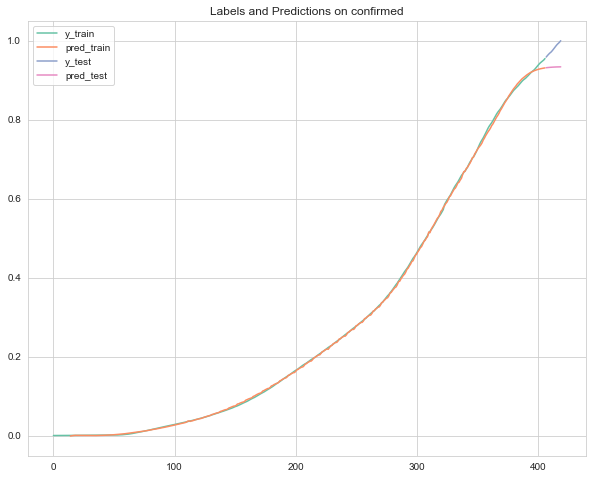

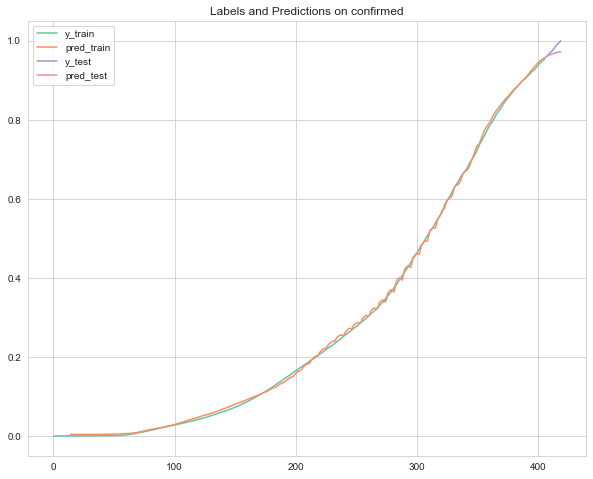

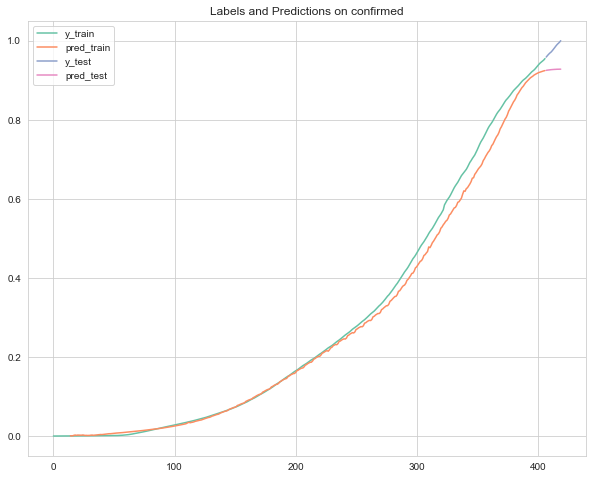

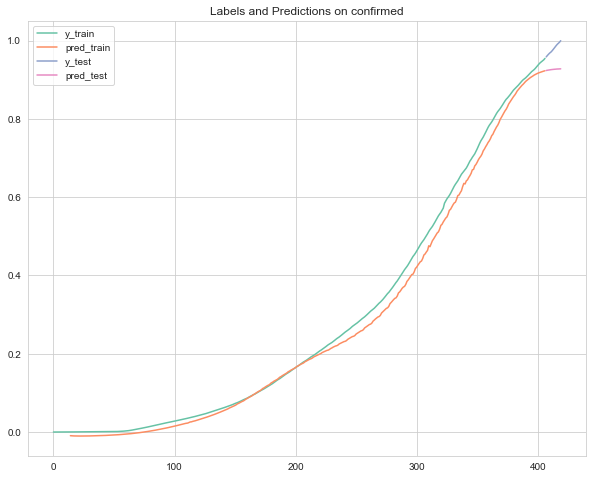

In [144]:
for model_type in model_types:
    configs = {
        'dataset': dataset,
        'model_path': f"./models/{model_type}_{'_'.join(labels)}",
        'model_type': model_type,
    }
    model = LSTMModel(**configs)
    model.read_model()
    model.plot()

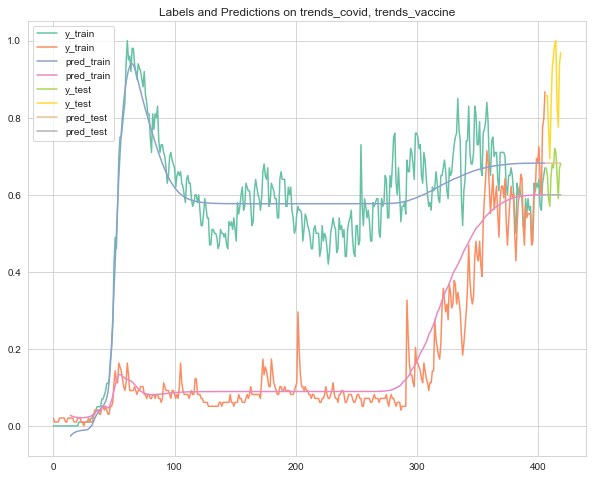

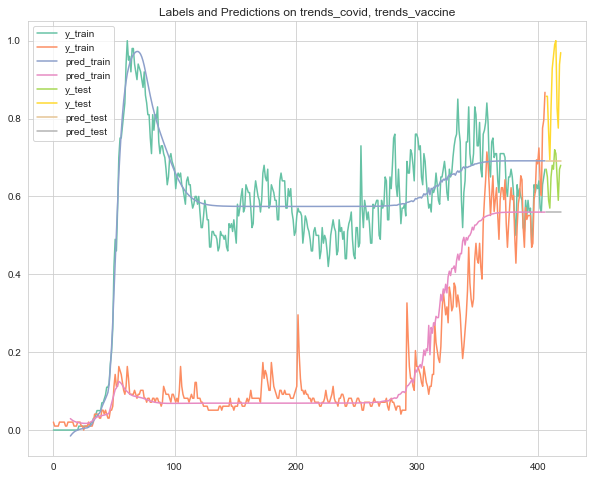

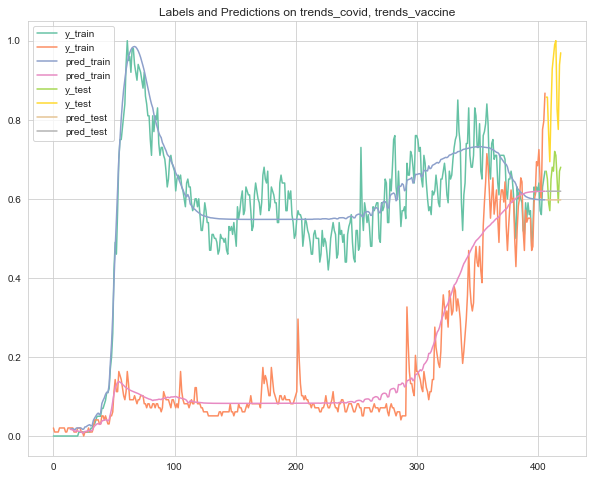

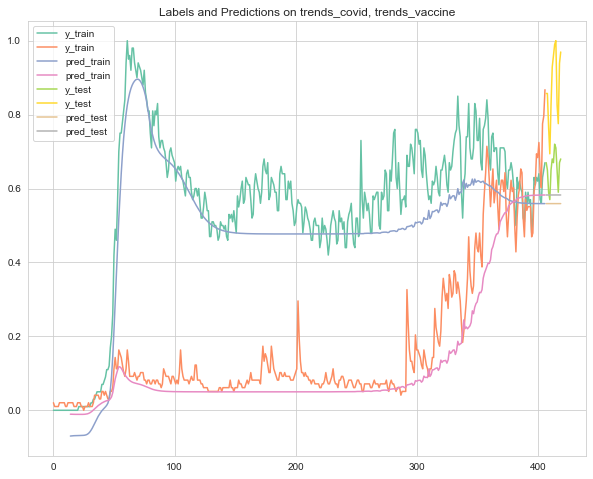

In [147]:
for model_type in model_types:
    configs = {
        'dataset': dataset,
        'model_path': f"./models/{model_type}_{'_'.join(labels)}",
        'model_type': model_type,
    }
    model = LSTMModel(**configs)
    model.read_model()
    model.plot()